In [1]:
!git clone https://github.com/Ruben-Boeckx/Experimental-Analysis-of-GNNs-for-CCF.git

Cloning into 'Experimental-Analysis-of-GNNs-for-CCF'...
remote: Enumerating objects: 409, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 409 (delta 107), reused 114 (delta 49), pack-reused 237
Receiving objects: 100% (409/409), 545.58 KiB | 2.62 MiB/s, done.
Resolving deltas: 100% (205/205), done.


In [2]:
%cd /content/Experimental-Analysis-of-GNNs-for-CCF
!git pull

/content/Experimental-Analysis-of-GNNs-for-CCF
Already up to date.


In [3]:
import torch
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install category_encoders rarfile

Looking in links: https://data.pyg.org/whl/torch-2.3.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=507268 sha256=3568e3c03b480030a8fba096070370c97a074387a6f7a497630535ef3802bdfa
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
Successfully built torch-scatter
Looking in links: https://data.pyg.org/whl/torch-2.3.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=1092566 sha256=856cf0d7fe5f8869f3c1dc2fbaa865375a1f1a20e814f1383208fde9772fc2a2
  Stored in directory: /root/.cache/pip/wheels/c9/dd/0f/a6a16f9f3b0236733d257b4b4ea91b548b984a341ed3b8f38c
Successfully built to

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/Experimental-Analysis-of-GNNs-for-CCF

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/Experimental-Analysis-of-GNNs-for-CCF


In [5]:
import numpy as np
import pandas as pd
import torch
from Graph.graph_construction import GraphConstruction
from Models.GNNs import GAT
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch_geometric.nn import to_hetero
from torch_geometric.loader import HGTLoader
from sklearn.metrics import average_precision_score, precision_score, recall_score, f1_score, roc_auc_score
from tqdm import tqdm
import matplotlib.pyplot as plt

In [6]:
# Download file from drive
file_id = '127LcoK858671J38JlmWOyATZEXZR4CyA'
rar_file_name = 'final_dataset.rar'
download_path = '/content/Experimental-Analysis-of-GNNs-for-CCF/' + rar_file_name

!gdown https://drive.google.com/uc?id={file_id} -O {download_path}

# Check if the file was downloaded successfully
import os
print(f"File exists: {os.path.exists(download_path)}")

# List files in the download directory
!ls -l /content/Experimental-Analysis-of-GNNs-for-CCF/

# Verify the RAR file
!file {download_path}

# Unrar file
!unrar x -Y "{download_path}" "/content/Dataset/"


Downloading...
From: https://drive.google.com/uc?id=127LcoK858671J38JlmWOyATZEXZR4CyA
To: /content/Experimental-Analysis-of-GNNs-for-CCF/final_dataset.rar
100% 23.3M/23.3M [00:01<00:00, 22.4MB/s]
File exists: True
total 23068
-rw-r--r-- 1 root root    52419 Jul 20 14:37 Bipartite_graph.ipynb
-rw-r--r-- 1 root root    65177 Jul 20 14:37 Example.ipynb
-rw-r--r-- 1 root root 23304861 Jul 20 15:22 final_dataset.rar
drwxr-xr-x 3 root root     4096 Jul 20 14:37 Graph
drwxr-xr-x 3 root root     4096 Jul 20 14:37 Models
-rw-r--r-- 1 root root   120023 Jul 20 14:37 Other_ML_techniques.ipynb
drwxr-xr-x 3 root root     4096 Jul 20 14:37 Preprocessing
-rw-r--r-- 1 root root      160 Jul 20 14:37 README.md
-rw-r--r-- 1 root root    55799 Jul 20 14:37 visualization.ipynb
/content/Experimental-Analysis-of-GNNs-for-CCF/final_dataset.rar: RAR archive data, v5

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/Experimental-Analysis-of-GNNs-for-CCF/final_

In [40]:
dataset = pd.read_csv('/content/Dataset/final_dataset.csv')

In [41]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [42]:
graph_constructor = GraphConstruction(dataset)
data = graph_constructor.apply_graph_construction()

Fraud Percentage in Train Mask: 50.00%
Fraud Percentage in Test Mask: 0.61%
Fraud Percentage in Val Mask: 0.63%
Graph Construction Successful!


In [43]:
model = GAT(
    hidden_dim=64,
    embedding_dim=64,
    output_dim=1,
    num_layers=3,
    dropout_rate=0.5,
    heads=1
)
model = to_hetero(model, data.metadata(), aggr='sum')
data, model = data.to(device), model.to(device)

optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
criterion = torch.nn.BCEWithLogitsLoss()

/usr/local/lib/python3.10/dist-packages/torch_geometric/nn/to_hetero_transformer.py:165: UserWarning: The type 'received by' contains invalid characters which may lead to unexpected behavior. To avoid any issues, ensure that your types only contain letters, numbers and underscores.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch_geometric/nn/to_hetero_transformer.py:165: UserWarning: The type 'rev_received by' contains invalid characters which may lead to unexpected behavior. To avoid any issues, ensure that your types only contain letters, numbers and underscores.
  warnings.warn(


In [44]:
kwargs = {'batch_size': 2048, 'num_workers': 2, 'persistent_workers': True}

train_loader = HGTLoader(
    data, num_samples={key: [2048] for key in data.node_types},
    input_nodes=('transaction', data['transaction'].train_mask), **kwargs)

test_loader = HGTLoader(
    data, num_samples={key: [2048] for key in data.node_types},
    input_nodes=('transaction', data['transaction'].test_mask), **kwargs)

val_loader = HGTLoader(
    data, num_samples={key: [2048] for key in data.node_types},
    input_nodes=('transaction', data['transaction'].val_mask), **kwargs)

In [45]:
@torch.no_grad()
def init_params():
    batch = next(iter(train_loader))
    batch = batch.to(device, 'edge_index')
    model(batch.x_dict, batch.edge_index_dict)

In [46]:
def train():
    model.train()
    total_examples = total_loss = 0

    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        batch = batch.to(device, 'edge_index')
        batch_size = batch['transaction'].batch_size
        out = model(batch.x_dict, batch.edge_index_dict)['transaction'][:batch_size]
        loss = criterion(out.squeeze(1), batch['transaction'].y[:batch_size].float())
        loss.backward()
        optimizer.step()

        total_examples += batch_size
        total_loss += float(loss) * batch_size

    scheduler.step()
    return total_loss / total_examples

In [47]:
@torch.no_grad()
def test(loader):
    model.eval()
    y_pred_probas = []
    y_trues = []
    total_examples = total_loss = 0

    for batch in tqdm(loader):
        batch = batch.to(device, 'edge_index')
        batch_size = batch['transaction'].batch_size
        y = batch['transaction'].y[:batch_size]
        y_hat = model(batch.x_dict, batch.edge_index_dict)['transaction'][:batch_size]
        loss = criterion(y_hat.squeeze(1), y.float())

        total_examples += batch_size
        total_loss += float(loss) * batch_size
        y_pred_probas.append(torch.sigmoid(y_hat.cpu()).numpy())
        y_trues.append(y.cpu().numpy())

    y_true = np.concatenate(y_trues)
    y_pred_proba = np.concatenate(y_pred_probas)

    return y_true, y_pred_proba, total_loss / total_examples

In [48]:
init_params()

training_losses = []
validation_losses = []

consecutive_increases = 0
max_consecutive_increases = 5

for epoch in range(50):
    loss = train()
    print(f'Epoch {epoch+1:02d}, Training loss: {loss:.4f}')
    training_losses.append(loss)

    y_val, y_val_pred_proba, val_loss = test(val_loader)
    print(f'Epoch {epoch+1:02d}, Validation loss: {val_loss:.4f}')
    validation_losses.append(val_loss)

    ap_val = average_precision_score(y_val, y_val_pred_proba)
    roc_val = roc_auc_score(y_val, y_val_pred_proba)

    print(f'Epoch {epoch+1:02d}, Average precision validation set: {ap_val:.2f}, ROC AUC validation set: {roc_val:.2f}')

    # Check for early stopping
    if epoch > 0 and val_loss >= validation_losses[-2]:
        consecutive_increases += 1
        if consecutive_increases >= max_consecutive_increases:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break
    else:
        consecutive_increases = 0

100%|██████████| 466/466 [01:42<00:00,  4.54it/s]


Epoch 01, Training loss: 0.4523


100%|██████████| 49/49 [00:02<00:00, 16.57it/s]


Epoch 01, Validation loss: 0.2046
Epoch 01, Average precision validation set: 0.41, ROC AUC validation set: 0.97


100%|██████████| 466/466 [01:47<00:00,  4.33it/s]


Epoch 02, Training loss: 0.2513


100%|██████████| 49/49 [00:03<00:00, 12.58it/s]


Epoch 02, Validation loss: 0.1471
Epoch 02, Average precision validation set: 0.41, ROC AUC validation set: 0.98


100%|██████████| 466/466 [01:39<00:00,  4.69it/s]


Epoch 03, Training loss: 0.1904


100%|██████████| 49/49 [00:05<00:00,  8.36it/s]


Epoch 03, Validation loss: 0.1277
Epoch 03, Average precision validation set: 0.50, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:43<00:00,  4.50it/s]


Epoch 04, Training loss: 0.1623


100%|██████████| 49/49 [00:03<00:00, 14.08it/s]


Epoch 04, Validation loss: 0.1144
Epoch 04, Average precision validation set: 0.59, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:53<00:00,  4.09it/s]


Epoch 05, Training loss: 0.1499


100%|██████████| 49/49 [00:03<00:00, 13.60it/s]


Epoch 05, Validation loss: 0.1076
Epoch 05, Average precision validation set: 0.64, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:59<00:00,  3.91it/s]


Epoch 06, Training loss: 0.1434


100%|██████████| 49/49 [00:03<00:00, 13.15it/s]


Epoch 06, Validation loss: 0.1164
Epoch 06, Average precision validation set: 0.66, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:51<00:00,  4.19it/s]


Epoch 07, Training loss: 0.1377


100%|██████████| 49/49 [00:06<00:00,  7.93it/s]


Epoch 07, Validation loss: 0.1085
Epoch 07, Average precision validation set: 0.71, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:49<00:00,  4.26it/s]


Epoch 08, Training loss: 0.1344


100%|██████████| 49/49 [00:04<00:00, 10.86it/s]


Epoch 08, Validation loss: 0.1040
Epoch 08, Average precision validation set: 0.70, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:51<00:00,  4.18it/s]


Epoch 09, Training loss: 0.1309


100%|██████████| 49/49 [00:03<00:00, 13.39it/s]


Epoch 09, Validation loss: 0.0946
Epoch 09, Average precision validation set: 0.72, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:55<00:00,  4.05it/s]


Epoch 10, Training loss: 0.1283


100%|██████████| 49/49 [00:05<00:00,  9.58it/s]


Epoch 10, Validation loss: 0.0884
Epoch 10, Average precision validation set: 0.72, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:55<00:00,  4.04it/s]


Epoch 11, Training loss: 0.1204


100%|██████████| 49/49 [00:05<00:00,  8.89it/s]


Epoch 11, Validation loss: 0.1032
Epoch 11, Average precision validation set: 0.75, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:55<00:00,  4.04it/s]


Epoch 12, Training loss: 0.1190


100%|██████████| 49/49 [00:03<00:00, 13.57it/s]


Epoch 12, Validation loss: 0.1041
Epoch 12, Average precision validation set: 0.75, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:51<00:00,  4.18it/s]


Epoch 13, Training loss: 0.1176


100%|██████████| 49/49 [00:03<00:00, 13.40it/s]


Epoch 13, Validation loss: 0.1008
Epoch 13, Average precision validation set: 0.76, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:52<00:00,  4.15it/s]


Epoch 14, Training loss: 0.1172


100%|██████████| 49/49 [00:06<00:00,  7.32it/s]


Epoch 14, Validation loss: 0.1072
Epoch 14, Average precision validation set: 0.76, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:50<00:00,  4.21it/s]


Epoch 15, Training loss: 0.1162


100%|██████████| 49/49 [00:03<00:00, 13.09it/s]


Epoch 15, Validation loss: 0.0991
Epoch 15, Average precision validation set: 0.76, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:55<00:00,  4.04it/s]


Epoch 16, Training loss: 0.1160


100%|██████████| 49/49 [00:03<00:00, 13.40it/s]


Epoch 16, Validation loss: 0.1037
Epoch 16, Average precision validation set: 0.76, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:55<00:00,  4.04it/s]


Epoch 17, Training loss: 0.1155


100%|██████████| 49/49 [00:03<00:00, 13.25it/s]


Epoch 17, Validation loss: 0.1030
Epoch 17, Average precision validation set: 0.76, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:55<00:00,  4.04it/s]


Epoch 18, Training loss: 0.1148


100%|██████████| 49/49 [00:03<00:00, 13.66it/s]


Epoch 18, Validation loss: 0.1005
Epoch 18, Average precision validation set: 0.77, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:51<00:00,  4.17it/s]


Epoch 19, Training loss: 0.1151


100%|██████████| 49/49 [00:05<00:00,  8.91it/s]


Epoch 19, Validation loss: 0.1041
Epoch 19, Average precision validation set: 0.76, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:56<00:00,  4.00it/s]


Epoch 20, Training loss: 0.1150


100%|██████████| 49/49 [00:05<00:00,  8.76it/s]


Epoch 20, Validation loss: 0.1031
Epoch 20, Average precision validation set: 0.76, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:52<00:00,  4.13it/s]


Epoch 21, Training loss: 0.1143


100%|██████████| 49/49 [00:06<00:00,  8.03it/s]


Epoch 21, Validation loss: 0.0949
Epoch 21, Average precision validation set: 0.76, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:53<00:00,  4.11it/s]


Epoch 22, Training loss: 0.1137


100%|██████████| 49/49 [00:05<00:00,  9.21it/s]


Epoch 22, Validation loss: 0.0946
Epoch 22, Average precision validation set: 0.77, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:58<00:00,  3.93it/s]


Epoch 23, Training loss: 0.1131


100%|██████████| 49/49 [00:03<00:00, 12.33it/s]


Epoch 23, Validation loss: 0.0946
Epoch 23, Average precision validation set: 0.77, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:55<00:00,  4.02it/s]


Epoch 24, Training loss: 0.1137


100%|██████████| 49/49 [00:03<00:00, 13.53it/s]


Epoch 24, Validation loss: 0.0952
Epoch 24, Average precision validation set: 0.77, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:56<00:00,  4.00it/s]


Epoch 25, Training loss: 0.1134


100%|██████████| 49/49 [00:03<00:00, 13.31it/s]


Epoch 25, Validation loss: 0.0942
Epoch 25, Average precision validation set: 0.77, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:47<00:00,  4.33it/s]


Epoch 26, Training loss: 0.1136


100%|██████████| 49/49 [00:04<00:00, 12.07it/s]


Epoch 26, Validation loss: 0.0952
Epoch 26, Average precision validation set: 0.76, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:45<00:00,  4.41it/s]


Epoch 27, Training loss: 0.1133


100%|██████████| 49/49 [00:05<00:00,  9.45it/s]


Epoch 27, Validation loss: 0.0949
Epoch 27, Average precision validation set: 0.77, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:46<00:00,  4.38it/s]


Epoch 28, Training loss: 0.1130


100%|██████████| 49/49 [00:05<00:00,  9.00it/s]


Epoch 28, Validation loss: 0.0944
Epoch 28, Average precision validation set: 0.77, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:46<00:00,  4.39it/s]


Epoch 29, Training loss: 0.1136


100%|██████████| 49/49 [00:06<00:00,  7.64it/s]


Epoch 29, Validation loss: 0.0954
Epoch 29, Average precision validation set: 0.77, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:44<00:00,  4.47it/s]


Epoch 30, Training loss: 0.1136


100%|██████████| 49/49 [00:05<00:00,  9.00it/s]


Epoch 30, Validation loss: 0.0951
Epoch 30, Average precision validation set: 0.77, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:45<00:00,  4.42it/s]


Epoch 31, Training loss: 0.1132


100%|██████████| 49/49 [00:04<00:00, 10.15it/s]


Epoch 31, Validation loss: 0.0943
Epoch 31, Average precision validation set: 0.77, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:46<00:00,  4.40it/s]


Epoch 32, Training loss: 0.1132


100%|██████████| 49/49 [00:03<00:00, 13.28it/s]


Epoch 32, Validation loss: 0.0944
Epoch 32, Average precision validation set: 0.77, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:46<00:00,  4.38it/s]


Epoch 33, Training loss: 0.1136


100%|██████████| 49/49 [00:03<00:00, 13.54it/s]


Epoch 33, Validation loss: 0.0940
Epoch 33, Average precision validation set: 0.77, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:47<00:00,  4.33it/s]


Epoch 34, Training loss: 0.1127


100%|██████████| 49/49 [00:03<00:00, 13.52it/s]


Epoch 34, Validation loss: 0.0941
Epoch 34, Average precision validation set: 0.77, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:44<00:00,  4.44it/s]


Epoch 35, Training loss: 0.1129


100%|██████████| 49/49 [00:03<00:00, 13.25it/s]


Epoch 35, Validation loss: 0.0943
Epoch 35, Average precision validation set: 0.77, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:46<00:00,  4.36it/s]


Epoch 36, Training loss: 0.1133


100%|██████████| 49/49 [00:03<00:00, 13.51it/s]


Epoch 36, Validation loss: 0.0944
Epoch 36, Average precision validation set: 0.77, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:46<00:00,  4.38it/s]


Epoch 37, Training loss: 0.1123


100%|██████████| 49/49 [00:04<00:00,  9.98it/s]


Epoch 37, Validation loss: 0.0942
Epoch 37, Average precision validation set: 0.77, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:45<00:00,  4.43it/s]


Epoch 38, Training loss: 0.1134


100%|██████████| 49/49 [00:06<00:00,  8.07it/s]


Epoch 38, Validation loss: 0.0945
Epoch 38, Average precision validation set: 0.77, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:45<00:00,  4.43it/s]


Epoch 39, Training loss: 0.1131


100%|██████████| 49/49 [00:06<00:00,  7.79it/s]


Epoch 39, Validation loss: 0.0947
Epoch 39, Average precision validation set: 0.77, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:44<00:00,  4.44it/s]


Epoch 40, Training loss: 0.1137


100%|██████████| 49/49 [00:06<00:00,  7.44it/s]


Epoch 40, Validation loss: 0.0939
Epoch 40, Average precision validation set: 0.77, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:45<00:00,  4.41it/s]


Epoch 41, Training loss: 0.1128


100%|██████████| 49/49 [00:05<00:00,  9.74it/s]


Epoch 41, Validation loss: 0.0941
Epoch 41, Average precision validation set: 0.77, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:47<00:00,  4.32it/s]


Epoch 42, Training loss: 0.1136


100%|██████████| 49/49 [00:03<00:00, 13.41it/s]


Epoch 42, Validation loss: 0.0944
Epoch 42, Average precision validation set: 0.77, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:47<00:00,  4.34it/s]


Epoch 43, Training loss: 0.1135


100%|██████████| 49/49 [00:03<00:00, 12.95it/s]


Epoch 43, Validation loss: 0.0943
Epoch 43, Average precision validation set: 0.77, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:47<00:00,  4.34it/s]


Epoch 44, Training loss: 0.1132


100%|██████████| 49/49 [00:03<00:00, 13.33it/s]


Epoch 44, Validation loss: 0.0941
Epoch 44, Average precision validation set: 0.77, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:47<00:00,  4.35it/s]


Epoch 45, Training loss: 0.1132


100%|██████████| 49/49 [00:03<00:00, 13.45it/s]


Epoch 45, Validation loss: 0.0943
Epoch 45, Average precision validation set: 0.77, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:46<00:00,  4.37it/s]


Epoch 46, Training loss: 0.1131


100%|██████████| 49/49 [00:03<00:00, 13.37it/s]


Epoch 46, Validation loss: 0.0943
Epoch 46, Average precision validation set: 0.77, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:46<00:00,  4.36it/s]


Epoch 47, Training loss: 0.1125


100%|██████████| 49/49 [00:03<00:00, 13.29it/s]


Epoch 47, Validation loss: 0.0944
Epoch 47, Average precision validation set: 0.77, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:45<00:00,  4.42it/s]


Epoch 48, Training loss: 0.1132


100%|██████████| 49/49 [00:04<00:00, 10.12it/s]


Epoch 48, Validation loss: 0.0943
Epoch 48, Average precision validation set: 0.77, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:45<00:00,  4.43it/s]


Epoch 49, Training loss: 0.1138


100%|██████████| 49/49 [00:05<00:00,  9.45it/s]


Epoch 49, Validation loss: 0.0944
Epoch 49, Average precision validation set: 0.77, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:44<00:00,  4.45it/s]


Epoch 50, Training loss: 0.1137


100%|██████████| 49/49 [00:06<00:00,  7.52it/s]


Epoch 50, Validation loss: 0.0944
Epoch 50, Average precision validation set: 0.77, ROC AUC validation set: 0.99


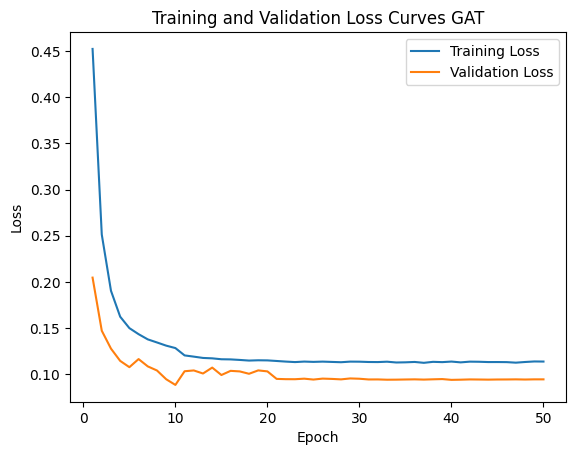

In [49]:
plt.figure()
plt.plot(range(1, len(training_losses)+1), training_losses, label='Training Loss')
plt.plot(range(1, len(validation_losses)+1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves GAT')
plt.legend()
plt.show()

In [50]:
y_test, y_test_pred_proba, test_loss = test(test_loader)
ap_test = average_precision_score(y_test, y_test_pred_proba)
roc_test = roc_auc_score(y_test, y_test_pred_proba)

print(f'Average precision testing set: {ap_test:.4f}, ROC AUC testing set: {roc_test:.4f}')

100%|██████████| 49/49 [00:05<00:00,  8.51it/s]


Average precision testing set: 0.7844, ROC AUC testing set: 0.9913
